In [2]:
import numpy as np
import pandas as pd
import basedosdados as bd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, precision_score, recall_score, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from statsmodels.tsa.arima.model import ARIMA

## Dados

In [3]:
# main_table = bd.read_sql(query = """ SELECT * FROM `rj-cor-dev.clima_pluviometro.main_table_fields_1H`""", billing_project_id = 'projeto-fgv1', use_bqstorage_api = True)
# main_table.to_csv('csvs/main_table.csv')

In [4]:
main_table = pd.read_csv("csvs/main_table.csv")
main_table.head()

,Unnamed: 0,id_h3,estacoes,chuva_15min,chuva_1h,chuva_4h,chuva_24h,chuva_96h,data_hora,estacao_ano,quinzenas,alagamento_inicio,alagamento_fim,alagamento_pop,alagamento_lat,alagamento_long,gravidade_alagamento
0,0,88a8a07191fffff,"Alto da boa vista,Barrinha,Rocinha",0.0,0.0,0.0,0.600326,6.400151,2015-01-01 00:00:00,Verão,quinzena_2015_1_1,NaN,NaN,NaN,NaN,NaN,NaN
1,1,88a8a07191fffff,"Alto da boa vista,Barrinha,Rocinha",0.0,0.0,0.0,0.600326,6.400151,2015-01-01 01:00:00,Verão,quinzena_2015_1_1,NaN,NaN,NaN,NaN,NaN,NaN
2,2,88a8a07191fffff,"Alto da boa vista,Barrinha,Rocinha",0.0,0.0,0.0,0.600326,6.400151,2015-01-01 02:00:00,Verão,quinzena_2015_1_1,NaN,NaN,NaN,NaN,NaN,NaN
3,3,88a8a07191fffff,"Alto da boa vista,Barrinha,Rocinha",0.0,0.0,0.0,0.600326,6.400151,2015-01-01 03:00:00,Verão,quinzena_2015_1_1,NaN,NaN,NaN,NaN,NaN,NaN
4,4,88a8a07191fffff,"Alto da boa vista,Barrinha,Rocinha",0.0,0.0,0.0,0.600326,6.400151,2015-01-01 04:00:00,Verão,quinzena_2015_1_1,NaN,NaN,NaN,NaN,NaN,NaN


## Pré-processamento

In [5]:
main_table['target'] = main_table['alagamento_pop'].notna() # 1 se houve alagamento, 0 se não houve
main_table['target'] = main_table['target'].astype(int)

# Aplicar one-hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_cols = one_hot_encoder.fit_transform(main_table[['estacao_ano']])
encoded_labels = one_hot_encoder.categories_[0]

# Adicionar as colunas codificadas ao DataFrame original
for i, label in enumerate(encoded_labels):
    main_table[f'estacao_ano_{label}'] = encoded_cols[:, i]

main_table.drop(columns=['data_hora','id_h3', 'estacao_ano', 'alagamento_fim',
                         'estacoes', 'Unnamed: 0', 'alagamento_pop', 'alagamento_inicio', 
                         'quinzenas', 'alagamento_lat', 'alagamento_long',
                         'gravidade_alagamento'], inplace=True)

main_table.fillna(0, inplace=True)

main_table

,chuva_15min,chuva_1h,chuva_4h,chuva_24h,chuva_96h,target,estacao_ano_Inverno,estacao_ano_Outono,estacao_ano_Primavera,estacao_ano_Verão
0,0.000000,0.000000,0.000000,0.600326,6.400151,0,0.0,0.0,0.0,1.0
1,0.000000,0.000000,0.000000,0.600326,6.400151,0,0.0,0.0,0.0,1.0
2,0.000000,0.000000,0.000000,0.600326,6.400151,0,0.0,0.0,0.0,1.0
3,0.000000,0.000000,0.000000,0.600326,6.400151,0,0.0,0.0,0.0,1.0
4,0.000000,0.000000,0.000000,0.600326,6.400151,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
76302,0.000002,0.400000,2.199972,26.399820,26.599871,0,0.0,0.0,1.0,0.0
76303,0.000002,0.000003,1.199995,26.399823,26.599875,0,0.0,0.0,1.0,0.0
76304,0.000000,0.000005,0.600007,10.799813,26.599879,0,0.0,0.0,1.0,0.0
76305,0.000000,0.000000,0.400009,10.599800,26.599879,0,0.0,0.0,1.0,0.0


In [6]:
X = main_table.drop(columns=['target'])
y = main_table['target']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

## Modelos

In [7]:
# Logistic Regression

logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("R²: ", r2_score(y_test, y_pred_lr))
print("Error: ", mean_squared_error(y_test, y_pred_lr))
print("Precison: ", precision_score(y_test, y_pred_lr))
print("Recall: ", recall_score(y_test, y_pred_lr))
conf = confusion_matrix(y_test, y_pred_lr)

print("confusion matrix:\n", conf)

Accuracy:  0.9342185725517603
R²:  -5.447822522370219
Error:  0.06578142744823971
Precison:  0.11042944785276074
Recall:  0.7627118644067796
confusion matrix:
 [[10604   725]
 [   28    90]]


In [8]:
# Neural Network

# 10 camadas ocultas com 10 neurônios cada relu
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000, activation='relu', 
                    solver='adam', random_state=1, early_stopping=True)
mlp.fit(X_train, y_train)

y_pred_nn = mlp.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_nn))
print("R²: ", r2_score(y_test, y_pred_nn))
print("Error: ", mean_squared_error(y_test, y_pred_nn))
print("Precison: ", precision_score(y_test, y_pred_nn))
print("Recall: ", recall_score(y_test, y_pred_nn))
conf = confusion_matrix(y_test, y_pred_nn)

print("confusion matrix:\n", conf)

Accuracy:  0.9909146501266708
R²:  0.10946408721579992
Error:  0.009085349873329257
Precison:  0.6944444444444444
Recall:  0.211864406779661
confusion matrix:
 [[11318    11]
 [   93    25]]


In [9]:
# Decision Tree

dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("R²: ", r2_score(y_test, y_pred_dt))
print("Error: ", mean_squared_error(y_test, y_pred_dt))
print("Precison: ", precision_score(y_test, y_pred_dt))
print("Recall: ", recall_score(y_test, y_pred_dt))
conf = confusion_matrix(y_test, y_pred_dt)

print("confusion matrix:\n", conf)

Accuracy:  0.989429544858915
R²:  -0.036104283143155946
Error:  0.010570455141085
Precison:  0.48717948717948717
Recall:  0.4830508474576271
confusion matrix:
 [[11269    60]
 [   61    57]]


In [10]:
# Random Forest

rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("R²: ", r2_score(y_test, y_pred_rf))
print("Error: ", mean_squared_error(y_test, y_pred_rf))
print("Precison: ", precision_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))
conf = confusion_matrix(y_test, y_pred_rf)

print("confusion matrix:\n", conf)

Accuracy:  0.9920503188608369
R²:  0.22078107631382493
Error:  0.0079496811391631
Precison:  0.6901408450704225
Recall:  0.4152542372881356
confusion matrix:
 [[11307    22]
 [   69    49]]


In [11]:
ARIMA model

from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

series = read_csv('csvs/main_table.csv', index_col=0, parse_dates=True, header=7)

series['data_hora'] = pd.to_datetime(series['data_hora'])
series['gravidade_alagamento'] = series['gravidade_alagamento'].replace('Baixo', 1)
series['gravidade_alagamento'] = series['gravidade_alagamento'].replace('Medio', 2)
series['gravidade_alagamento'] = series['gravidade_alagamento'].replace('Alto', 3)
series['gravidade_alagamento'] = series['gravidade_alagamento'].replace('Critico', 4)
series['gravidade_alagamento'] = series['gravidade_alagamento'].fillna(0)
series['gravidade_alagamento'] = series['gravidade_alagamento'].astype(int)

one_hot_encoder = OneHotEncoder(sparse=False)
encoded_cols = one_hot_encoder.fit_transform(series[['estacao_ano']])
encoded_labels = one_hot_encoder.categories_[0]

# Adicionar as colunas codificadas ao DataFrame original
for i, label in enumerate(encoded_labels):
    series[f'estacao_ano_{label}'] = encoded_cols[:, i]

# delete unwanted columns

#series.drop(columns=['id_h3', 'estacao_ano', 'alagamento_fim', 'estacoes', 'alagamento_pop', 'alagamento_inicio', 'quinzenas', 'alagamento_lat', 'alagamento_long'], inplace=True)
print(series.head())
series = series[['data_hora', 'chuva_24h']]
print(series.head())
series.plot(x = 'data_hora', y = 'chuva_24h')

pyplot.show()


# fit arima model


# fit model

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())


,ds,y
0,2015-01-01 00:00:00,0
1,2015-01-01 01:00:00,0
2,2015-01-01 02:00:00,0
3,2015-01-01 03:00:00,0
4,2015-01-01 04:00:00,0


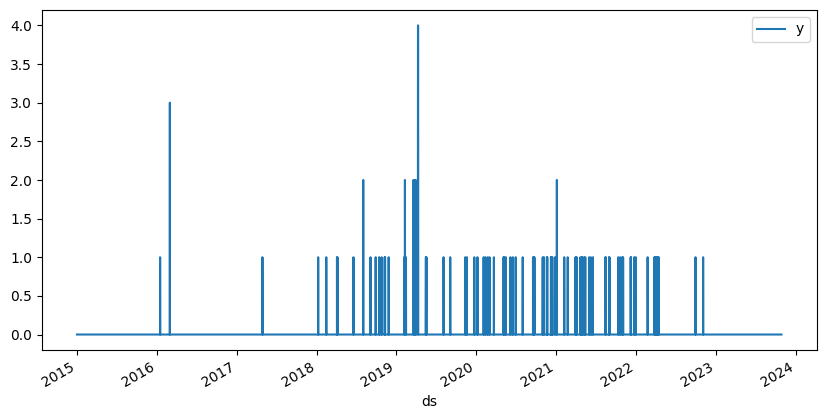

In [21]:
from neuralprophet import NeuralProphet, set_log_level

df = pd.read_csv('csvs/main_table.csv')
df['data_hora'] = pd.to_datetime(df['data_hora'])
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Baixo', 1)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Baixo', 1)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Medio', 2)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Alto', 3)
df['gravidade_alagamento'] = df['gravidade_alagamento'].replace('Critico', 4)
df['gravidade_alagamento'] = df['gravidade_alagamento'].fillna(0)
df['gravidade_alagamento'] = df['gravidade_alagamento'].astype(int)
df = df[['data_hora', 'gravidade_alagamento']]
df.columns = ['ds', 'y']
plt = df.plot(x="ds", y="y", figsize=(10, 5))

df.head()

In [23]:

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model with default parameters
m = NeuralProphet()
# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df, freq="H")

df_future = m.make_future_dataframe(df, n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

ValueError: Column ds has duplicate values. Please remove duplicates.